In [1]:

# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap


c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Loading
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]


In [3]:

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

In [4]:
# Step 2: Data Preprocessing
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

In [5]:
# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:

# Step 3: Define TabTransformer Model
# Embedding dimensions
embedding_dim = 32
num_heads = 4
num_transformer_blocks = 2

In [8]:
def build_tabtransformer_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Add a sequence length dimension (e.g., sequence length = 1)
    x = tf.expand_dims(inputs, axis=1)  # Shape becomes (batch_size, 1, input_dim)

    # Transformer Encoder Block
    x = layers.Dense(embedding_dim, activation="relu")(x)
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(embedding_dim, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)

    # Output Layer
    x = layers.GlobalAveragePooling1D()(x)  # Removes sequence length dimension
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Build the model
model = build_tabtransformer_model(x_train.shape[1])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 41)        0           ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1, 32)        1344        ['tf.expand_dims[0][0]']         
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 1, 32)       16800       ['dense_1[0][0]',                
 eadAttention)                                                    'dense_1[0][0]']            

In [9]:
# Step 4: Train the Model
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val)
)


Epoch 1/20
1575/1575 [==============================] - 19s 11ms/step - loss: 0.0533 - accuracy: 0.9795 - val_loss: 0.0353 - val_accuracy: 0.9875
Epoch 2/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0313 - accuracy: 0.9879 - val_loss: 0.0251 - val_accuracy: 0.9910
Epoch 3/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0272 - accuracy: 0.9894 - val_loss: 0.0221 - val_accuracy: 0.9921
Epoch 4/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0255 - accuracy: 0.9900 - val_loss: 0.0202 - val_accuracy: 0.9925
Epoch 5/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0241 - accuracy: 0.9910 - val_loss: 0.0211 - val_accuracy: 0.9928
Epoch 6/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0223 - accuracy: 0.9919 - val_loss: 0.0188 - val_accuracy: 0.9928
Epoch 7/20
1575/1575 [==============================] - 17s 11ms/step - loss: 0.0208 - accuracy: 0.9924 - val_loss: 0.0176 -

705/705 [==============================] - 4s 5ms/step - loss: 1.5872 - accuracy: 0.7821
Test Loss: 1.5871933698654175, Test Accuracy: 0.7820706367492676


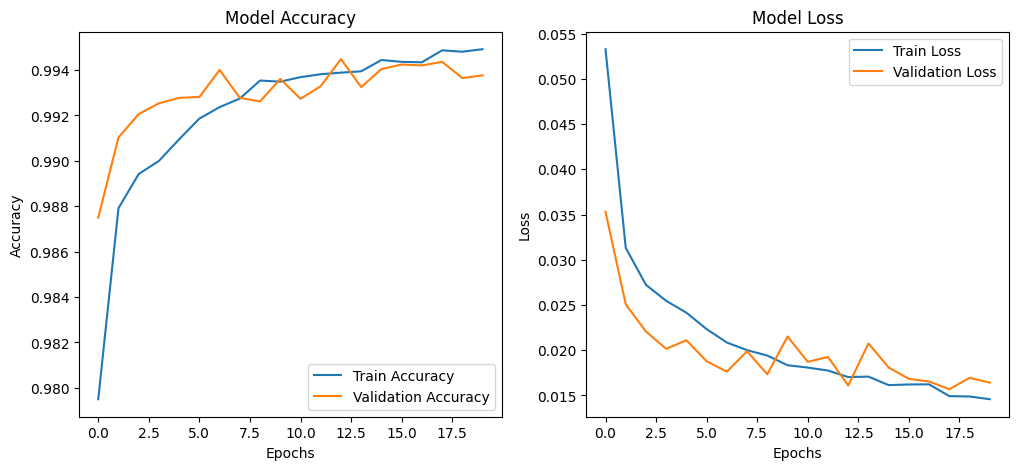

In [10]:
# Step 5: Evaluate the Model
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Step 6: Visualizations
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 3s 4ms/step


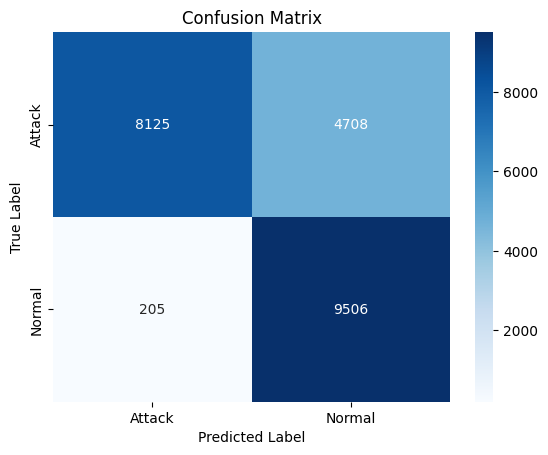

              precision    recall  f1-score   support

      Attack       0.98      0.63      0.77     12833
      Normal       0.67      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [11]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))



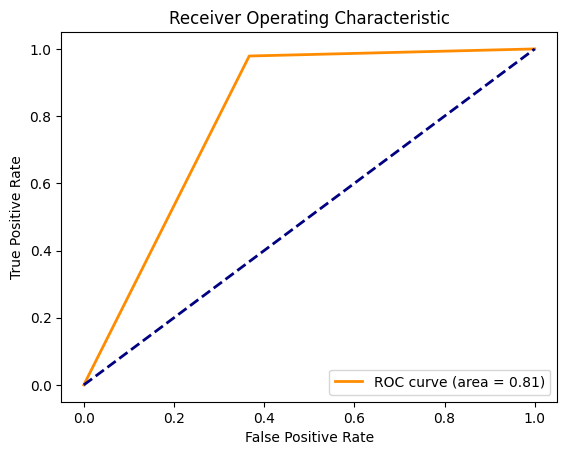

In [12]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



In [13]:
# Step 7: SHAP Analysis
# Explain predictions with SHAP
explainer = shap.KernelExplainer(model.predict, X_test[:100])  # Use a subset for SHAP due to compute constraints
shap_values = explainer.shap_values(X_test[:100])

# Summary Plot
shap.summary_plot(shap_values[0], X_test[:100], feature_names=train.columns[:-1])

# Force Plot (First Instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[:1], feature_names=train.columns[:-1])

# Feature Importance Plot
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", feature_names=train.columns[:-1])


4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6600/6600 [==============================] - 29s 4ms/step


  1%|          | 1/100 [00:32<53:38, 32.51s/it]

6600/6600 [==============================] - 31s 5ms/step


  2%|▏         | 2/100 [01:06<54:03, 33.10s/it]

6600/6600 [==============================] - 31s 5ms/step


  3%|▎         | 3/100 [01:39<54:08, 33.49s/it]

6600/6600 [==============================] - 32s 5ms/step


  4%|▍         | 4/100 [02:14<53:58, 33.74s/it]

6600/6600 [==============================] - 35s 5ms/step


  5%|▌         | 5/100 [02:53<56:30, 35.69s/it]

6600/6600 [==============================] - 35s 5ms/step


  6%|▌         | 6/100 [03:30<56:57, 36.36s/it]

6600/6600 [==============================] - 30s 5ms/step


  7%|▋         | 7/100 [04:03<54:38, 35.25s/it]

6600/6600 [==============================] - 31s 5ms/step


  8%|▊         | 8/100 [04:37<53:07, 34.65s/it]

6600/6600 [==============================] - 31s 5ms/step


  9%|▉         | 9/100 [05:10<51:47, 34.14s/it]

6600/6600 [==============================] - 30s 5ms/step


 10%|█         | 10/100 [05:43<50:51, 33.90s/it]

6600/6600 [==============================] - 34s 5ms/step


 11%|█         | 11/100 [06:20<51:40, 34.83s/it]

6600/6600 [==============================] - 34s 5ms/step


 12%|█▏        | 12/100 [06:57<52:11, 35.59s/it]

6600/6600 [==============================] - 34s 5ms/step


 13%|█▎        | 13/100 [07:34<52:14, 36.03s/it]

6600/6600 [==============================] - 32s 5ms/step


 14%|█▍        | 14/100 [08:09<51:13, 35.73s/it]

6600/6600 [==============================] - 34s 5ms/step


 15%|█▌        | 15/100 [08:45<50:42, 35.80s/it]

6600/6600 [==============================] - 30s 5ms/step


 16%|█▌        | 16/100 [09:18<48:38, 34.74s/it]

6600/6600 [==============================] - 32s 5ms/step


 17%|█▋        | 17/100 [10:00<51:06, 36.94s/it]

6600/6600 [==============================] - 34s 5ms/step


 18%|█▊        | 18/100 [10:40<51:47, 37.89s/it]

6600/6600 [==============================] - 35s 5ms/step


 19%|█▉        | 19/100 [11:21<52:28, 38.87s/it]

6600/6600 [==============================] - 35s 5ms/step


 20%|██        | 20/100 [12:02<52:47, 39.60s/it]

6600/6600 [==============================] - 35s 5ms/step


 21%|██        | 21/100 [12:42<52:09, 39.61s/it]

6600/6600 [==============================] - 37s 6ms/step


 22%|██▏       | 22/100 [13:25<52:45, 40.58s/it]

6600/6600 [==============================] - 38s 6ms/step


 23%|██▎       | 23/100 [14:09<53:21, 41.58s/it]

6600/6600 [==============================] - 38s 6ms/step


 24%|██▍       | 24/100 [14:53<53:37, 42.33s/it]

6600/6600 [==============================] - 39s 6ms/step


 25%|██▌       | 25/100 [15:39<54:16, 43.42s/it]

6600/6600 [==============================] - 37s 6ms/step


 26%|██▌       | 26/100 [16:23<53:47, 43.61s/it]

6600/6600 [==============================] - 36s 6ms/step


 27%|██▋       | 27/100 [17:05<52:39, 43.28s/it]

6600/6600 [==============================] - 37s 6ms/step


 28%|██▊       | 28/100 [17:48<51:48, 43.18s/it]

6600/6600 [==============================] - 36s 6ms/step


 29%|██▉       | 29/100 [18:31<51:05, 43.17s/it]

6600/6600 [==============================] - 36s 6ms/step


 30%|███       | 30/100 [19:14<50:09, 43.00s/it]

6600/6600 [==============================] - 35s 5ms/step


 31%|███       | 31/100 [19:55<48:39, 42.31s/it]

6600/6600 [==============================] - 32s 5ms/step


 32%|███▏      | 32/100 [20:33<46:25, 40.97s/it]

6600/6600 [==============================] - 32s 5ms/step


 33%|███▎      | 33/100 [21:10<44:37, 39.96s/it]

6600/6600 [==============================] - 33s 5ms/step


 34%|███▍      | 34/100 [21:49<43:43, 39.74s/it]

6600/6600 [==============================] - 33s 5ms/step


 35%|███▌      | 35/100 [22:26<42:00, 38.77s/it]

6600/6600 [==============================] - 33s 5ms/step


 36%|███▌      | 36/100 [23:02<40:22, 37.85s/it]

6600/6600 [==============================] - 33s 5ms/step


 37%|███▋      | 37/100 [23:38<39:18, 37.43s/it]

6600/6600 [==============================] - 32s 5ms/step


 38%|███▊      | 38/100 [24:15<38:35, 37.34s/it]

6600/6600 [==============================] - 32s 5ms/step


 39%|███▉      | 39/100 [24:53<38:04, 37.45s/it]

6600/6600 [==============================] - 32s 5ms/step


 40%|████      | 40/100 [25:30<37:27, 37.46s/it]

6600/6600 [==============================] - 32s 5ms/step


 41%|████      | 41/100 [26:08<36:53, 37.51s/it]

6600/6600 [==============================] - 32s 5ms/step


 42%|████▏     | 42/100 [26:46<36:17, 37.54s/it]

6600/6600 [==============================] - 32s 5ms/step


 43%|████▎     | 43/100 [27:23<35:44, 37.62s/it]

6600/6600 [==============================] - 32s 5ms/step


 44%|████▍     | 44/100 [28:01<35:06, 37.62s/it]

6600/6600 [==============================] - 32s 5ms/step


 45%|████▌     | 45/100 [28:39<34:27, 37.59s/it]

6600/6600 [==============================] - 32s 5ms/step


 46%|████▌     | 46/100 [29:16<33:45, 37.50s/it]

6600/6600 [==============================] - 32s 5ms/step


 47%|████▋     | 47/100 [29:54<33:11, 37.57s/it]

6600/6600 [==============================] - 32s 5ms/step


 48%|████▊     | 48/100 [30:31<32:34, 37.58s/it]

6600/6600 [==============================] - 32s 5ms/step


 49%|████▉     | 49/100 [31:09<32:00, 37.66s/it]

6600/6600 [==============================] - 33s 5ms/step


 50%|█████     | 50/100 [31:48<31:43, 38.07s/it]

6600/6600 [==============================] - 31879s 5s/step


 51%|█████     | 51/100 [9:23:13<130:33:31, 9592.08s/it]

6600/6600 [==============================] - 32s 5ms/step


 52%|█████▏    | 52/100 [9:23:50<89:40:33, 6725.69s/it] 

6600/6600 [==============================] - 32s 5ms/step


 53%|█████▎    | 53/100 [9:24:28<61:36:40, 4719.16s/it]

6600/6600 [==============================] - 7188s 1s/step


 54%|█████▍    | 54/100 [11:24:29<69:49:00, 5463.93s/it]

6600/6600 [==============================] - 90s 14ms/step


 55%|█████▌    | 55/100 [11:26:11<48:11:25, 3855.23s/it]

6600/6600 [==============================] - 97s 15ms/step


 56%|█████▌    | 56/100 [11:27:59<33:22:49, 2731.12s/it]

5103/6600 [======================>.......] - ETA: 12:45

 56%|█████▌    | 56/100 [12:11:28<9:34:44, 783.73s/it]  


KeyboardInterrupt: 